In [2]:
import os
import pandas as pd
import numpy as np
import sys
import pyreadr

# Data Cleaning 

## Election Results

In [5]:
# most recent county created in 2001 (not including Alaska)     
# data goes from 2002 - 
gub_df = pd.read_csv('Data/Election/gub_res.csv', dtype={
    'fips': 'float64',
    'election_type': 'string',
    'office': 'string',
    'seat_status': 'string',
    'democratic_raw_votes': 'float64',
    'republican_raw_votes': 'float64',
    'gov_raw_county_vote_totals_two_party': 'float64'})
gub_df.drop(gub_df.columns[0], axis=1, inplace=True)
gub_df.rename(columns={'election_year': 'year'}, inplace=True)
gub_df['result'] = gub_df['democratic_raw_votes'] / gub_df['gov_raw_county_vote_totals_two_party']


pres_df = pd.read_csv('Data/Election/pres_res.csv', dtype={
    'fips': 'float64',
    'election_type': 'string',
    'office': 'string',
    'seat_status': 'string',
    'democratic_raw_votes': 'float64',
    'republican_raw_votes': 'float64',
    'gov_raw_county_vote_totals_two_party': 'float64'})
pres_df.drop(pres_df.columns[0], axis=1, inplace=True)
pres_df.rename(columns={'election_year': 'year'}, inplace=True)
pres_df['result'] = pres_df['democratic_raw_votes'] / pres_df['pres_raw_county_vote_totals_two_party']

senate_df = pd.read_csv('Data/Election/senate_res.csv', dtype={
    'fips': 'float64',
    'election_type': 'string',
    'office': 'string',
    'seat_status': 'string',
    'democratic_raw_votes': 'float64',
    'republican_raw_votes': 'float64',
    'gov_raw_county_vote_totals_two_party': 'float64'})
senate_df.drop(senate_df.columns[0], axis=1, inplace=True)
senate_df.rename(columns={'election_year': 'year'}, inplace=True)
senate_df['result'] = senate_df['democratic_raw_votes'] / senate_df['senate_raw_county_vote_totals_two_party']
senate_df = senate_df[(senate_df['democratic_raw_votes'] != 0) & (senate_df['republican_raw_votes'] != 0)] # remove uncontested races

senate_df

,year,fips,election_type,office,seat_status,democratic_raw_votes,republican_raw_votes,senate_raw_county_vote_totals_two_party,result
0,2002.0,1001.0,G,SEN,Republican Senator re-election,3819.0,10687.0,14506.0,0.263270
1,2004.0,1001.0,G,SEN,Republican Senator re-election,3960.0,15728.0,19688.0,0.201138
2,2008.0,1001.0,G,SEN,Republican Senator re-election,5316.0,17941.0,23257.0,0.228576
3,2010.0,1001.0,G,SEN,Republican Senator re-election,3978.0,13980.0,17958.0,0.221517
5,2016.0,1001.0,G,SEN,Republican Senator re-election,6331.0,18220.0,24551.0,0.257871
...,...,...,...,...,...,...,...,...,...
21883,2008.0,56045.0,S,SEN,Appointed Republican Senator Election,572.0,2789.0,3361.0,0.170187
21884,2012.0,56045.0,G,SEN,Republican Senator re-election,336.0,2887.0,3223.0,0.104251
21885,2014.0,56045.0,G,SEN,Republican Senator re-election,194.0,2027.0,2221.0,0.087348
21886,2018.0,56045.0,G,SEN,Republican Senator re-election,321.0,2275.0,2596.0,0.123652


## Demographics

In [7]:
demographic_parameters = ['median_household_income', 'unemployment_rate', 'bachelors_or_higher', 
                          'age_60_years_and_older', 'native_pop_ratio', 'percent_minority', 'pop_density']


In [8]:

def create_demographic_df(folder_path, demographic, column_name, new_name):
    dfs = []
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            year = file.split(demographic)[0]  # Extract the year from the file name
            df = pd.read_csv(os.path.join(folder_path, file), usecols=['GEO_ID', column_name], skiprows=[1])
            df['GEO_ID'] = df['GEO_ID'].str[-5:] #only the last 5 numbers correspond to an actual county
            df['GEO_ID'] = df['GEO_ID'].astype(float)
            df.insert(0, 'year', year)
            df['year'] = df['year'].astype(float)
            dfs.append(df)
    demographic_df = pd.concat(dfs, ignore_index=True).rename(columns={'GEO_ID': 'fips', column_name: new_name})
    return demographic_df


def create_density_df(folder_path, demographic, column_name, new_name):
    dfs = []
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            for year in range (2010, 2021, 2):
                df = pd.read_csv(os.path.join(folder_path, file), usecols=['fips', column_name], skiprows=[1])
                df.insert(0, 'year', year)
                df['year'] = df['year'].astype(float)
                dfs.append(df)
    
    demographic_df = pd.concat(dfs, ignore_index=True).rename(columns={column_name: new_name})
    return demographic_df
    
    
# Age (60 years and older)------------------------------------------------------------------------------------------
age_df = create_demographic_df('Data/Demographics/Age', 'Age', 'S0101_C02_028E', 'age_60_years_and_older')
native_pop_df = create_demographic_df('Data/Demographics/Birth', 'Birth', 'B05002_002E', 'native_pop')
total_pop_df = create_demographic_df('Data/Demographics/Birth', 'Birth', 'B05002_001E', 'total_pop')
native_df = pd.DataFrame({
    'fips': native_pop_df['fips'],  # Include 'fips' for reference
    'year': native_pop_df['year'],  # Include 'year' for reference
    'native_pop_ratio': native_pop_df['native_pop'] / total_pop_df['total_pop']
})
education_df = create_demographic_df('Data/Demographics/Education', 'Education', 'S1501_C02_015E', 'bachelors_or_higher')
employment_df = create_demographic_df('Data/Demographics/Employment', 'Employment', 'DP03_0009PE', 'unemployment_rate')
income_df = create_demographic_df('Data/Demographics/Income', 'Income', 'S1901_C01_012E', 'median_household_income')
white_df = create_demographic_df('Data/Demographics/Race', 'Race', 'DP05_0032PE', 'percent_white')
white_df = (
    white_df
    .assign(
        percent_white=lambda x: pd.to_numeric(x['percent_white'], errors='coerce'),
    )
)
minority_df = pd.DataFrame({
    'fips': white_df['fips'],  # Include 'fips' for reference
    'year': white_df['year'],  # Include 'year' for reference
    'percent_minority': 100 - white_df['percent_white']
})
#black_df = create_demographic_df('Data/Demographics/Race', 'Race', 'DP05_0033PE', 'percent_black')
#hispanic_df = create_demographic_df('Data/Demographics/Race', 'Race', 'DP05_0034PE', 'percent_hispanic')
#asian_df = create_demographic_df('Data/Demographics/Race', 'Race', 'DP05_0039PE', 'percent_asian')
density_df = create_density_df('Data/Demographics/Density', 'Density', 'POPDEN_COU', 'pop_density')
# Combine------------------------------------------------------------------------------------------
demographics_df = pd.merge(income_df, age_df, on=['fips', 'year'], how='inner')
demographics_df = pd.merge(demographics_df, density_df, on=['fips', 'year'], how='inner')
demographics_df = pd.merge(demographics_df, education_df, on=['fips', 'year'], how='inner')
demographics_df = pd.merge(demographics_df, native_df, on=['fips', 'year'], how='inner')
demographics_df = pd.merge(demographics_df, employment_df, on=['fips', 'year'], how='inner')
demographics_df = pd.merge(demographics_df, minority_df, on=['fips', 'year'], how='inner')
#demographics_df = pd.merge(demographics_df, black_df, on=['fips', 'year'], how='inner')
#demographics_df = pd.merge(demographics_df, hispanic_df, on=['fips', 'year'], how='inner')
#demographics_df = pd.merge(demographics_df, asian_df, on=['fips', 'year'], how='inner')

C:\Users\beqia\AppData\Local\Temp\ipykernel_14572\4641461.py:6: DtypeWarning: Columns (292) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), usecols=['GEO_ID', column_name], skiprows=[1])


,year,fips,median_household_income,age_60_years_and_older,pop_density,bachelors_or_higher,native_pop_ratio,unemployment_rate,percent_minority
0,2010.0,1003.0,50147,15.6,145.78,28.7,0.963508,6.6,13.8
1,2010.0,1005.0,33219,11.0,28.50,12.6,0.971912,9.6,50.3
2,2010.0,1007.0,41770,9.7,35.81,10.2,0.993233,9.1,15.8
3,2010.0,1009.0,45549,12.5,91.70,12.8,0.952815,7.5,4.9
4,2010.0,1011.0,31602,8.3,16.63,9.6,0.988648,11.2,76.3
...,...,...,...,...,...,...,...,...,...
19299,2020.0,72145.0,20126,27.1,"1,186.85",21.7,0.994128,18.1,NaN
19300,2020.0,72147.0,14040,28.1,162.42,13.0,0.995416,13.1,NaN
19301,2020.0,72149.0,19355,24.5,619.95,19.7,0.998447,20.0,NaN
19302,2020.0,72151.0,16828,28.4,551.05,17.6,0.997292,18.1,NaN


Income: S1901_C01_

## Merge

In [11]:
def remove_missing_values(df):
    df = (
        df
        .dropna(subset=['result'])
        .assign(
            median_household_income=lambda x: pd.to_numeric(x['median_household_income'], errors='coerce'),
            unemployment_rate=lambda x: pd.to_numeric(x['unemployment_rate'], errors='coerce'),
            bachelors_or_higher=lambda x: pd.to_numeric(x['bachelors_or_higher'], errors='coerce'),
            age_60_years_and_older=lambda x: pd.to_numeric(x['age_60_years_and_older'], errors='coerce'),
            percent_minority=lambda x:pd.to_numeric(x['percent_minority'], errors='coerce'),
            #percent_black=lambda x: pd.to_numeric(x['percent_black'], errors='coerce'),
            #percent_hispanic=lambda x: pd.to_numeric(x['percent_hispanic'], errors='coerce'),
            #percent_asian=lambda x: pd.to_numeric(x['percent_asian'], errors='coerce'),
            pop_density=lambda x: pd.to_numeric(x['pop_density'], errors='coerce'),
        )
        .dropna(subset=demographic_parameters)
    )
    return df

senate_combined_df = pd.merge(demographics_df, senate_df, on=['fips', 'year'], how='inner')
gub_combined_df = pd.merge(demographics_df, gub_df, on=['fips', 'year'], how='inner')
pres_combined_df = pd.merge(demographics_df, pres_df, on=['fips', 'year'], how='inner')

senate_combined_df = remove_missing_values(senate_combined_df)
gub_combined_df = remove_missing_values(gub_combined_df)
pres_combined_df = remove_missing_values(pres_combined_df)

senate_combined_df = senate_combined_df.drop(columns=['seat_status'], axis=1)


In [12]:
def print_summary_statistics(df):
    # Generate summary statistics
    summary_stats = df.describe().T[['count', 'mean', 'std', 'min', 'max']]
    
    # Print the summary statistics
    print("{:<30} {:<15} {:<15} {:<15} {:<15} {:<15}".format("Variable", "Observations", "Mean", "Std Dev", "Min", "Max"))
    print("-" * 90)
    for index, row in summary_stats.iterrows():
        print("{:<30} {:<15} {:<15.2f} {:<15.2f} {:<15.2f} {:<15.2f}".format(
            index, int(row['count']), row['mean'], row['std'], row['min'], row['max']
        ))

# Call the function to print summary stats
print_summary_statistics(pres_combined_df)

Variable                       Observations    Mean            Std Dev         Min             Max            
------------------------------------------------------------------------------------------
year                           5915            2014.00         2.00            2012.00         2016.00        
fips                           5915            30507.51        14948.66        1003.00         56045.00       
median_household_income        5915            45886.35        11204.90        18972.00        125672.00      
age_60_years_and_older         5915            15.43           4.41            0.00            51.40          
pop_density                    5915            98.57           154.91          0.10            999.95         
bachelors_or_higher            5915            19.04           8.35            0.00            67.20          
native_pop_ratio               5915            0.96            0.05            0.59            1.00           
unemployment_rate    

### Export as CSV

In [14]:
#gub_combined_df.to_csv('gub_combined.csv')
#pres_combined_df.to_csv('pres_combined.csv')
#senate_combined_df.to_csv('senate_combined.csv')

## Analysis

Random Forest on Presidential Election Data:
10-Fold Cross-Validation R^2 Scores: [0.53977772 0.58901749 0.55635621 0.5619831  0.55335655 0.57923173
 0.58133487 0.62163194 0.54908349 0.53526982]
Mean R^2 Score: 0.5667042924770376
Standard Deviation of R^2 Scores: 0.02493413275365857
Mean Squared Error (MSE): 0.009557617634618555
R^2 Score: 0.567611261207053

Feature Importances:
                   Feature  Importance
5         percent_minority    0.279071
2      bachelors_or_higher    0.164784
6              pop_density    0.153885
1        unemployment_rate    0.135857
4         native_pop_ratio    0.098549
0  median_household_income    0.095394
3   age_60_years_and_older    0.072459


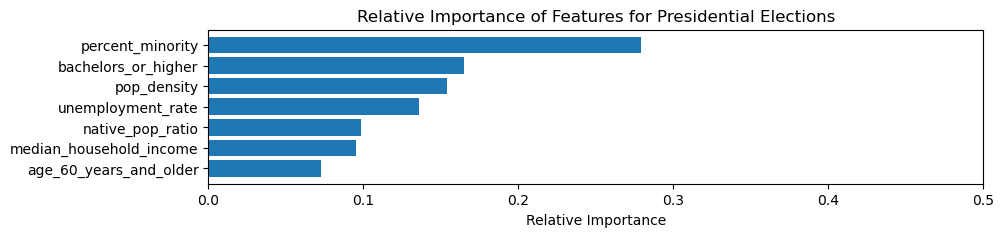

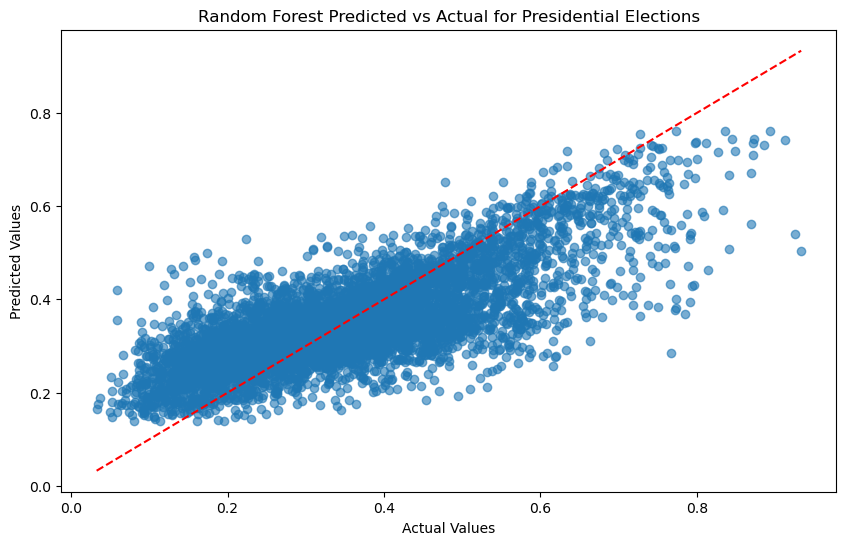

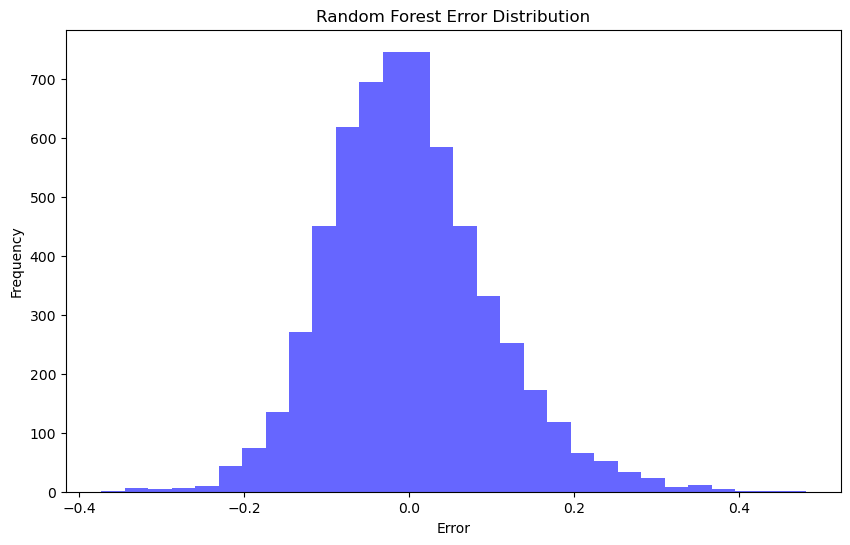

____________________________________________________________
Random Forest on Gubernatorial Election Data:
10-Fold Cross-Validation R^2 Scores: [0.39369363 0.35129623 0.42870391 0.34831797 0.37957437 0.42587069
 0.38410136 0.37151125 0.37654336 0.36217195]
Mean R^2 Score: 0.38217847217249434
Standard Deviation of R^2 Scores: 0.02619686251940818


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

def print_feature_importances(importances, features, title="Feature Importances"):
    feature_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importances:")
    print(feature_importances)
    
def plot_feature_importances(importances, features, title="Feature Importances"):
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 2))  # Adjusted height from 6 to 4
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], align="center")
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.xlim(0, 0.5)
    plt.show()

def plot_predictions_vs_actual(y_test, y_pred, title="Predicted vs Actual Values"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.show()

def plot_error_distribution(y_test, y_pred, title="Error Distribution"):
    errors = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, alpha=0.6, color='blue')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

def random_forest(df, graph_title):
    # Define features and target
    X = df[demographic_parameters]
    y = df['result']
    
    # Create the Random Forest model with optimized parameters
    model = RandomForestRegressor(
        bootstrap=True,
        max_depth=20,
        max_features='sqrt',
        min_samples_leaf=4,
        min_samples_split=2,
        n_estimators=300,
        random_state=0
    )

    # 10-fold cross-validation
    cv = KFold(n_splits=10, shuffle=True, random_state=0)  # 10-fold CV with shuffling

    # Cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    print("10-Fold Cross-Validation R^2 Scores:", cv_scores)
    print("Mean R^2 Score:", cv_scores.mean())
    print("Standard Deviation of R^2 Scores:", cv_scores.std())

    # Cross-validation predictions
    y_pred = cross_val_predict(model, X, y, cv=cv)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print("Mean Squared Error (MSE):", mse)
    print("R^2 Score:", r2)

    # Plotting visualizations
    print_feature_importances(model.fit(X, y).feature_importances_, X.columns, title=f"Relative Importance of Features for {graph_title} Elections")
    plot_feature_importances(model.feature_importances_, X.columns, title=f"Relative Importance of Features for {graph_title} Elections")
    plot_predictions_vs_actual(y, y_pred, title=f"Random Forest Predicted vs Actual for {graph_title} Elections")
    plot_error_distribution(y, y_pred, title="Random Forest Error Distribution")

print("Random Forest on Presidential Election Data:")
random_forest(pres_combined_df, "Presidential")
print('____________________________________________________________')
print("Random Forest on Gubernatorial Election Data:")
random_forest(gub_combined_df, "Gubernatorial")
print('____________________________________________________________')
print("Random Forest on Senate Election Data:")
random_forest(senate_combined_df, "Senatorial")